# Machine Learning Pipelines Lab

## Modeling Retail Product Returns

You've been hired as a data scientist at a major retail company that wants to predict which products will be returned based on product characteristics and customer behavior. Product returns are costly to the business in terms of logistics, restocking, and customer satisfaction. The company wants to identify potentially high-return products early in their lifecycle so they can improve product descriptions, adjust marketing, or even reconsider stocking certain items.

Your task is to build a machine learning pipeline that can predict which products are likely to have high return rates. The pipeline should follow the six-step process covered in the module:

- Define business context and model goals
- Understand and explore the data
- Design and implement preprocessing
- Create a complete model pipeline
- Optimize and tune the pipeline
- Evaluate and understand the final model

### Business Context:
In the retail business, product returns create a challenging balance of concerns. The company faces significant costs for each return: shipping expenses, labor for processing, product devaluation, and inventory carrying costs. According to the VP of Operations, processing a return costs $15-25 per item, while profit margins typically range from $10-40.

However, the marketing team has valid concerns about being too conservative. Their analysis shows that for every product removed due to return concerns, they lose 3-5 potential sales. The merchandising team estimates that 70% of customers who can't find a specific product will purchase from a competitor instead.

As a data scientist building this predictive model, you need to balance catching problematic high-return products while avoiding unnecessary restrictions to the product catalog. This suggests that neither a pure recall-focused approach (catching all high-return products but generating many false alarms) nor a precision-focused approach (minimizing false alarms but missing many problematic products) would be optimal for the company's overall profitability.

Think about what metric would best capture this need for balance between identifying truly problematic products while minimizing false positives that could unnecessarily limit the product selection?

In [1]:
# CodeGrade step0
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay

# Load data
df_returns = pd.read_csv('product_return_data.csv')

In [2]:
# Run this cell without changes
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              660 non-null    float64
 1   weight             665 non-null    float64
 2   days_since_launch  675 non-null    float64
 3   product_category   670 non-null    object 
 4   seasonal_item      680 non-null    object 
 5   advertised_as      675 non-null    object 
 6   high_return_rate   700 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 38.4+ KB


## Part 1: Define Business Context and Model Goals
- The business goal is to identify products likely to have high return rates
- Need to balance both false positives and false negatives
- Determine your primary metric to optimize model for
- Use the scoring string name from https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [3]:
# CodeGrade step1
# Assign string name
primary_metric = "f1"

## Part 2: Data Understanding and Exploration
Your tasks: 
- Perform exploratory data analysis to understand the data better
- Visualize relationships between features and the target
    - Use sns.histplot() for numeric features, set hue='high_return_rate'
    - Use sns.barplot() for categorical features

In [4]:
# CodeGrade step2
# Display first few rows
first_five = df_returns.head()

# Check missing values per column
missing_values = df_returns.isnull().sum()

# Check class distribution counts using pandas (use normalize=True)
class_dist = df_returns['high_return_rate'].value_counts(normalize=True)

In [5]:
# Run this cell without changes to display results
print("First 5 rows of our dataset:")
print(first_five)

# Check missing values
print("\nMissing values in each column:")
print(missing_values)

# Check class distribution
print("\nClass distribution (high return rate):")
print(class_dist)

First 5 rows of our dataset:
       price    weight  days_since_launch product_category seasonal_item  \
0  52.127115  3.898765         322.159329         Clothing            No   
1  48.597563  2.909821                NaN         Clothing           Yes   
2  39.603677  1.831876         278.825821         Clothing            No   
3        NaN  1.858977         335.112842         Clothing            No   
4   1.272153  1.778375          10.742482      Electronics           NaN   

  advertised_as  high_return_rate  
0      Standard                 0  
1      Standard                 0  
2        Budget                 0  
3       Premium                 0  
4        Budget                 1  

Missing values in each column:
price                40
weight               35
days_since_launch    25
product_category     30
seasonal_item        20
advertised_as        25
high_return_rate      0
dtype: int64

Class distribution (high return rate):
high_return_rate
1    0.79
0    0.21
Name: pr

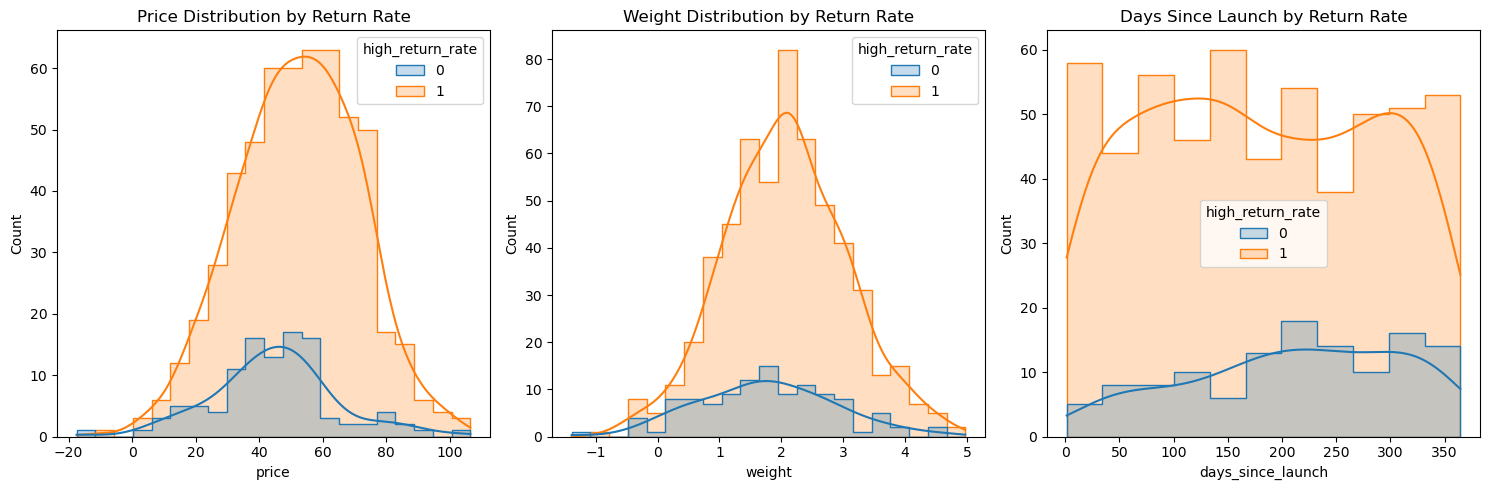

In [7]:
# CodeGrade step3
# Visualize numeric feature relations
plt.figure(figsize=(15, 5))

# Create subplots for each numerical feature
# Use sns.histplot and set hue='high_return_rate'
plt.subplot(1, 3, 1)
price_hist = sns.histplot(data=df_returns, x='price', hue='high_return_rate', kde=True, element="step")
plt.title('Price Distribution by Return Rate')

plt.subplot(1, 3, 2)
weight_hist = sns.histplot(data=df_returns, x='weight', hue='high_return_rate', kde=True, element="step")
plt.title('Weight Distribution by Return Rate')

plt.subplot(1, 3, 3)
days_since_hist = sns.histplot(data=df_returns, x='days_since_launch', hue='high_return_rate', kde=True, element="step")
plt.title('Days Since Launch by Return Rate')

plt.tight_layout()
plt.show()

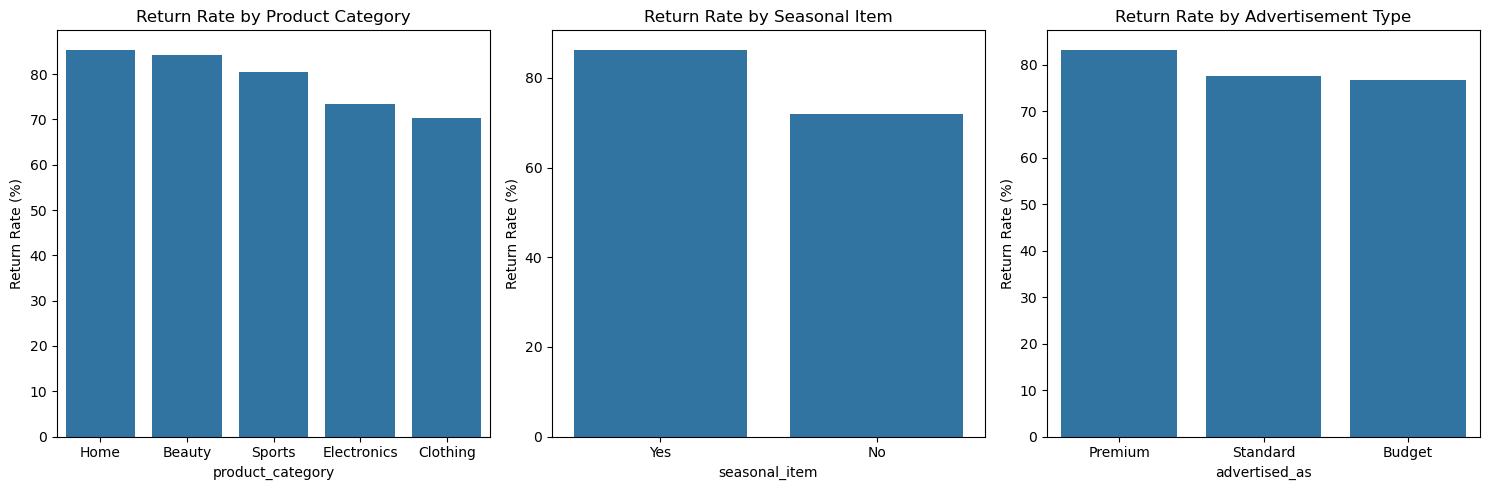

In [8]:
# CodeGrade step4
# Visualize categorical feature relations
# Use pandas groupby to calculate high_return_rate means for each categorical variable (this will give you return rate because its binary)
# Convert values to percentage (multiply each by 100)
# Product Category
category_return_rates = df_returns.groupby('product_category')['high_return_rate'].mean().sort_values(ascending=False) * 100

# Seasonal Item
seasonal_return_rates = df_returns.groupby('seasonal_item')['high_return_rate'].mean().sort_values(ascending=False) * 100

# Advertised As
advertised_return_rates= df_returns.groupby('advertised_as')['high_return_rate'].mean().sort_values(ascending=False) * 100

# Figure plot
plt.figure(figsize=(15, 5))

# Create subplots for each categorical feature - use the return rate objects above
# Product Category
plt.subplot(1, 3, 1)
category_bar = sns.barplot(x=category_return_rates.index, y=category_return_rates.values)
plt.title('Return Rate by Product Category')
plt.ylabel('Return Rate (%)')

# Seasonal Item
plt.subplot(1, 3, 2)
seasonal_bar = sns.barplot(x=seasonal_return_rates.index, y=seasonal_return_rates.values)
plt.title('Return Rate by Seasonal Item')
plt.ylabel('Return Rate (%)')

# Advertised As
plt.subplot(1, 3, 3)
advertised_bar = sns.barplot(x=advertised_return_rates.index, y=advertised_return_rates.values)
plt.title('Return Rate by Advertisement Type')
plt.ylabel('Return Rate (%)')

plt.tight_layout()
plt.show()

## Part 3: Design and Implement Preprocessing Pipeline
Your tasks: 
- Define feature groups
- Create preprocessing pipelines
    - Use SimpleImputer to fill null values (mean and most common)
    - Use StandardScaler for numerical features
    - Use OnehotEncoder (set drop='first' and handle_unknown='ignore') for categorical features
- Create Columntransformer preprocessing object

In [9]:
# CodeGrade step5
# Define your feature groups as lists
numeric_features = ['price', 'weight', 'days_since_launch']
categorical_features = ['product_category', 'seasonal_item', 'advertised_as']

# Create transformer for numerical features
# Create a pipeline with imputation and standard scaling
# Fill null values with mean
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create transformer for categorical features
# Create a pipeline with imputation and onehotencoding
# Fill null values with most common
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Part 4: Create Complete Model Pipeline
Your tasks: 
- Separate data into target and features
- Split data into training and testing sets (75-25 split) and set random_state = 42
- Combine preprocessing with models
    - Name the final step in both pipelines 'classifier' for ease of access


In [10]:
# CodeGrade step6
# Split data into features and target
X = df_returns.drop('high_return_rate', axis=1)
y = df_returns['high_return_rate']

# Split into training and test sets (75% train, 25% test) use random_state = 42 and set stratify = y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create Random Forest pipeline (set random_state=42)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Create Logistic Regression pipeline (set random_state=42 and max_inter=1000)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

## Part 5: Optimize and Tune the Pipeline
Your tasks:
- Define parameter grids using the provided hyperparameters and values
    - Ensure proper naming/access convention for your keys
- Perform grid searches
    - For the scoring parameter select your primary metric and another secondary metric
    - Ensure that both gridsearches are optimizing for your primary metric
    - Compare performance

For Random Forest Grid:
- strategy': ['mean', 'median'] (numerical subpipeline)
- n_estimators': [50, 100]
- max_depth': [10, 20, None]
- min_samples_leaf': [1, 2]
- class_weight': ['balanced', None]

For Logistic Regression Grid:
- strategy': ['mean', 'median'] (numerical subpipeline)
- C': [0.1, 1.0, 10.0]
- class_weight': ['balanced', None]
- solver': ['liblinear', 'saga']

In [11]:
# CodeGrade step7
# Define parameter grid for Random Forest
rf_param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', None]
}

# Define parameter grid for Logistic Regression
lr_param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__class_weight': ['balanced', None],
    'classifier__solver': ['liblinear', 'saga']
}

# Define scoring (should be a list)
scoring = [primary_metric, 'recall']

# Perform grid search for Random Forest (make sure to set scoring and refit appropriately)
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring=scoring,
    refit=primary_metric,
    return_train_score=True,
    n_jobs=-1
)

# Fit the Random Forest grid search
rf_grid_search.fit(X_train, y_train)

# Perform grid search for Logistic Regression (make sure to set scoring and refit appropriately)
lr_grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=5,
    scoring=scoring,
    refit=primary_metric,
    return_train_score=True,
    n_jobs=-1
)

# Fit the Logistic Regression grid search
lr_grid_search.fit(X_train, y_train)

# Compare models
rf_best_cvscore = rf_grid_search.best_score_
lr_best_cvscore = lr_grid_search.best_score_

In [12]:
# Run this cell without changes to display results
print(f"Best Random Forest f1_score: {rf_best_cvscore:.4f}")
print(f"Best Logistic Regression f1_score: {lr_best_cvscore:.4f}")

# Select the best model based on recall
if rf_best_cvscore >= lr_best_cvscore:
    best_model = rf_grid_search
    model_name = "Random Forest"
else:
    best_model = lr_grid_search
    model_name = "Logistic Regression"

print(f"\nBest model: {model_name}")

Best Random Forest f1_score: 0.9136
Best Logistic Regression f1_score: 0.8855

Best model: Random Forest


## Part 6: Final Model Evaluation and Understanding
Your tasks:
- Evaluate the best model on testing data
- Interpret model behavior (feature importance/coefficients)

In [13]:
# CodeGrade step8
# Get the best model from gridsearch
final_model = (rf_grid_search if rf_best_cvscore >= lr_best_cvscore else lr_grid_search).best_estimator_

# Make predictions on test set using final_model
y_pred = final_model.predict(X_test)

# Calculate test set f1_score
test_f1 = f1_score(y_test, y_pred)

# Create classification report
cr = classification_report(y_test, y_pred)

# Create confusion matrix object
cm = confusion_matrix(y_test, y_pred)


===== Final Model Evaluation =====
Test set f1 score: 0.9164

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.35      0.51        37
           1       0.85      0.99      0.92       138

    accuracy                           0.86       175
   macro avg       0.89      0.67      0.71       175
weighted avg       0.87      0.86      0.83       175

Confusion Matrix:


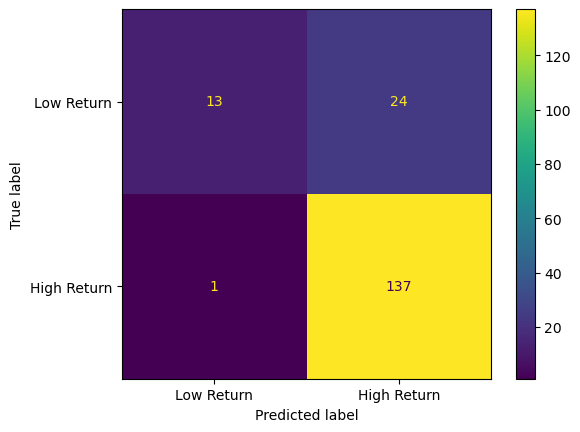

In [14]:
# Run this cell without changes to display results
print(f"\n===== Final Model Evaluation =====")
print(f"Test set f1 score: {test_f1:.4f}")
print("\nClassification Report:")
print(cr)
print(f"Confusion Matrix:")
ConfusionMatrixDisplay(cm, display_labels=['Low Return', 'High Return']).plot();

In [15]:
# CodeGrade step9
# Get feature names after preprocessing
feature_names = []

# Numerical feature names directly to list
feature_names.extend(numeric_features)

# For categorical features, get the encoded feature names
# This is a bit complex because we need to extract the names from the preprocessing pipeline
# Access preprocessor
preprocessor = final_model.named_steps['preprocessor']

# Access the categorical Onehotencoder
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']

# Extract feature names
encoded_cat_features = cat_encoder.get_feature_names_out(categorical_features)

# Extend list with categorical feature names
feature_names.extend(encoded_cat_features)

# Extract model from final_model pipelne (use named_steps)
rf_model = final_model.named_steps['classifier']

# Get feature importances
if hasattr(rf_model, "feature_importances_"):
    importances = rf_model.feature_importances_
else:
    importances = np.abs(rf_model.coef_[0])

# DataFrame for easier viewing
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting high to low
feature_imp = feature_imp.sort_values('Importance', ascending=False)

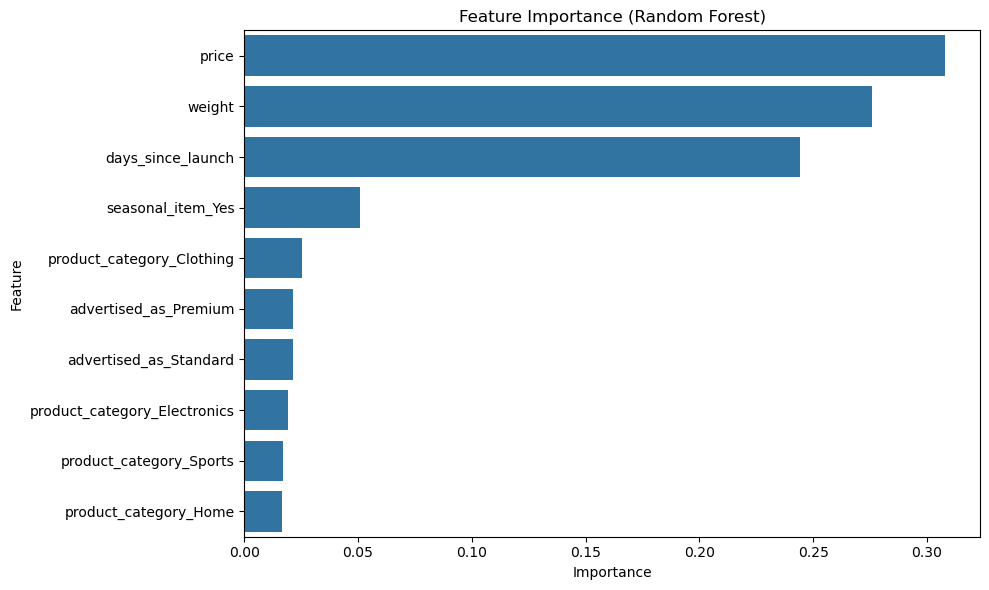


===== Model Summary =====
Selected model: Random Forest
Business goal: Identify products likely to have high return rates
Primary metric: f1
Test set performance: 0.9164

Key preprocessing decisions:
  Numeric features imputation strategy: mean
  Categorical features handled with one-hot encoding
  All numeric features standardized to mean=0, variance=1


In [16]:
# Run this cell without changes
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Summarize modeling decisions
print("\n===== Model Summary =====")
print(f"Selected model: {model_name}")
print("Business goal: Identify products likely to have high return rates")
print(f"Primary metric: {primary_metric}")
print(f"Test set performance: {test_f1:.4f}")
print("\nKey preprocessing decisions:")
print(f"  Numeric features imputation strategy: {best_model.best_params_.get('preprocessor__num__imputer__strategy', 'Not specified')}")
print("  Categorical features handled with one-hot encoding")
print("  All numeric features standardized to mean=0, variance=1")